# Preparing MODIS data

We'll try to setup a workflow for dealing with MODIS data.

The different steps of the workflow include:
- Downloading the data (the entire MODIS archive is stored on a USGS FTP server which can be accessed anonymously by anyone; and there's a python library that can help us do that)
- Reading the datasets: MODIS data come as HDF4, which adds a bit of complexity to reading the data (HDF4 is also the reason we are not using rasterio, which does not seem to play well with the HDF4 driver yet)
- Crop the data (in case you do not want the full 1200x1200 km extent of a MODIS tile)
- Filter cloud and bad quality data (MODIS always come with some quality assessment layers which provide pixel wise quality information on the data).

## Downloading the data

We'll use the `pymodis` library to do that. We're downloading a NDVI time-series from the MODIS VI product at 1km resolution. The data comes in 1200x1200 km tiles, hdf format, sinusoidal projection, and 16 days composites.

The entire download size should be about 200 Mb

In [2]:
from pymodis import downmodis
import glob

# Variables for data download
dest = "data/" # This directory must already exist BTW
tiles = "h18v03" # That's the MODIS tile covering northern Europe
day = "2015.11.18"
enddate = "2015.01.01" # The download works backward, so that enddate is anterior to day=
product = "MOD13A2.006"

# Instantiate download class, connect and download
modis_down = downmodis.downModis(destinationFolder=dest, tiles=tiles, today=day, enddate=enddate, product=product)
modis_down.connect()
modis_down.downloadsAllDay()

# Check that the data has been downloaded
MODIS_files = glob.glob(dest + '*.hdf')
print MODIS_files

['data/MOD13A2.A2015161.h18v03.006.2015301071821.hdf', 'data/MOD13A2.A2015225.h18v03.006.2015305201536.hdf', 'data/MOD13A2.A2015177.h18v03.006.2015301215033.hdf', 'data/MOD13A2.A2015241.h18v03.006.2015305211851.hdf', 'data/MOD13A2.A2015129.h18v03.006.2015299152843.hdf', 'data/MOD13A2.A2015065.h18v03.006.2015298000808.hdf', 'data/MOD13A2.A2015081.h18v03.006.2015298184905.hdf', 'data/MOD13A2.A2015209.h18v03.006.2015304025821.hdf', 'data/MOD13A2.A2015305.h18v03.006.2015335131539.hdf', 'data/MOD13A2.A2015321.h18v03.006.2015343140626.hdf', 'data/MOD13A2.A2015033.h18v03.006.2015296122831.hdf', 'data/MOD13A2.A2015289.h18v03.006.2015317212129.hdf', 'data/MOD13A2.A2015193.h18v03.006.2015304005053.hdf', 'data/MOD13A2.A2015145.h18v03.006.2015301000016.hdf', 'data/MOD13A2.A2015257.h18v03.006.2015306150600.hdf', 'data/MOD13A2.A2015049.h18v03.006.2015297001558.hdf', 'data/MOD13A2.A2015113.h18v03.006.2015299024206.hdf', 'data/MOD13A2.A2015097.h18v03.006.2015299003940.hdf', 'data/MOD13A2.A2015001.h18v

## Read the data into python

Now that the data have been downloaded, we need to read them in python, so that we can work on the following steps of the preprocessing later on. In order to setup the workflow we'll start with a single file.

### Explore the HDF4 architecture

HDF4 data are composed of sub-datasets; they can be listed using the `GetSubDatasets()` function. In order to know a-priori what every subdataset is, refer to the [MODIS product table](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table); it's a very important reference to keep, I personally almost always keep that page open when working with MODIS data.

In [3]:
from osgeo import gdal
import numpy as np

# Get subdatasets of the first file of the MODIS_file list
sds = gdal.Open(MODIS_files[0], gdal.GA_ReadOnly).GetSubDatasets()

# Looking at the product description in the 'MODIS products table', we know that NDVI is the first SDS and there is a 
# pixel reliability layer in the 12th SDS. Let's see what they look like when opened with GDAL
# Note, unlike getRasterBand() which starts counting from one, the output of GetSubDatasets() is simply a list of tupples
# so normal python index applies here
print sds[0]
print sds[11]

('HDF4_EOS:EOS_GRID:"data/MOD13A2.A2015161.h18v03.006.2015301071821.hdf":MODIS_Grid_16DAY_1km_VI:1 km 16 days NDVI', '[1200x1200] 1 km 16 days NDVI MODIS_Grid_16DAY_1km_VI (16-bit integer)')
('HDF4_EOS:EOS_GRID:"data/MOD13A2.A2015161.h18v03.006.2015301071821.hdf":MODIS_Grid_16DAY_1km_VI:1 km 16 days pixel reliability', '[1200x1200] 1 km 16 days pixel reliability MODIS_Grid_16DAY_1km_VI (8-bit integer)')


In [4]:
# Every subdataset is represented by a tupple; we only need the first element of that tupple to read the datasets with gdal.Open

# Open NDVI dataset, we'll keep it and re-use it later for the dimension and projection information it contains
vi = gdal.Open(sds[0][0])

### Read data as numpy arrays

We'll do that using a loop to import both layers (NDVI and QA layer) in a single array, and allowing some subsetting (cropping) to be done.

When filling an array from a gdal dataset using the `ReadAsArray()` function, there is an option to set an offset (x and y) and a size (x and y). The offset corresponds to the distance (in pixel) from the top left corner of the image from where the data starts being read. The size is the width and height of the chunck being read.

In [11]:
# Define offsets and width of data chunck we want to read as array
width = 500
height = 500
xOff = 400
yOff = 400

# Read data in arrays
# NDVI
vi_src = gdal.Open(sds[0][0])
vi_np = vi_src.ReadAsArray(xOff, yOff, width, height)

# QA
QA_src = gdal.Open(sds[11][0])
QA_np = QA_src.ReadAsArray(xOff, yOff, width, height)


# Let's take a quick look at the dimension of that first array
print vi_np.shape

(500, 500)


## Filter data

This step is actually very easy since it only requires a bit of array arithmetic.

From the [product description](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod13a2) of the MODIS 1 km VI dataset, we know that a pixel reliability (SDS 12) of 0 correspond to good data, 1 corresponds to marginal data, and anything other than that should not be used (actually snow and ice is still a valid land observation, but of very little relevance when working with vegetation...).

So let's do it. Invalid data are replaced by -3000, which is the noData fill value of the dataset.

In [12]:
# Perform value replacement and drop QA layer
vi_np[np.logical_and(QA_np != 0, QA_np != 1)] = -3000
# De-allocate QA array
QA_np = None

Let's visualize the result

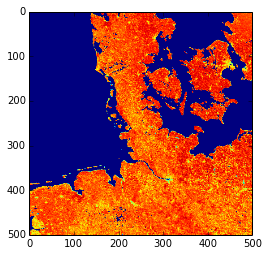

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(vi_np)
plt.show()

## Write output to disk

Because we modified the extent of the data, we need to be very careful when writing this output to disk. If we would simply use the positioning of the source dataset to define the position of our output dataset (this can be done using `CreateCopy()`), we would be ignoring the offset we used when reading the data into an array, and the resulting image would be misslocated. We therefore need to reflect that offset in the position of the image (called GeoTransforms).

Let's write a function that modify the geoTreansform of a dataset based on an x and y offset.

In [55]:
# Geotransform is a tupple of 6, that contains offset and resolution of the dataset. See gdal doc for more details
def updateGeoTransforms(srcGeo, xOff, yOff):
    """
    Create a new geotransform list based on a source geoTransform and an offset
    Returns a list of 6
    :param srcGeo: The geoTransfor of the uncroped dataset retrieved using GetGeoTransform()
    :param xOff: x offset used for cropping
    :param yOff: y offset used for cropping
    """
    out = [srcGeo[0] + xOff * srcGeo[1], srcGeo[1], srcGeo[2], srcGeo[3] + yOff * srcGeo[5], srcGeo[4], srcGeo[5]]
    return out

Let's now create a new dataset that will allow us to write the array to disk.

In [56]:
import os

# Get Geotransforms and projection of original dataset
geoT = vi.GetGeoTransform()
proj = vi.GetProjection()

# Create new dataset to write array to
outfile_name = os.path.join(dest, 'MODIS_NDVI.tif')
driver = gdal.GetDriverByName('GTiff')
# Create empty dataset using array dimentions
dataset = driver.Create(outfile_name, width, height, 1, gdal.GDT_Int16)
dataset.SetGeoTransform(updateGeoTransforms(geoT, xOff, yOff))
dataset.SetProjection(proj)
dataset.GetRasterBand(1).SetNoDataValue(-3000)
dataset.GetRasterBand(1).WriteArray(vi_np)

0

In [ ]:
# Close datasets and unallocate arrays
dataset = None
vi_np = None
vi = None
vi_src = None
QA_src = None

## Process all the files

Now that we have the workflow setup for a file, we can simply put it in a loop so that we can iterate over all files. So putting it all together, we get:

In [57]:
import glob
import os
from osgeo import gdal
import numpy as np

# Set variables
inDir = "data/" 
outDir = "data/out"
width = 500
height = 500
xOff = 400
yOff = 400

# Create output directory if it doesn't already exist
if not os.path.exists(outDir):
    os.makedirs(outDir)

# Get file list
MODIS_files = glob.glob(inDir + '*.hdf')

# Define functions
def updateGeoTransforms(srcGeo, xOff, yOff):
    """
    Create a new geotransform list based on a source geoTransform and an offset
    Returns a list of 6
    :param srcGeo: The geoTransfor of the uncropped dataset retrieved using GetGeoTransform()
    :param xOff: x offset used for cropping
    :param yOff: y offset used for cropping
    """
    out = [srcGeo[0] + xOff * srcGeo[1], srcGeo[1], srcGeo[2], srcGeo[3] + yOff * srcGeo[5], srcGeo[4], srcGeo[5]]
    return out

def makeFileName(x, suffix, ext = "tif"):
    """
    Generate a new file name by appending a suffix and changing the extension of an input file name 
    :param x: string, input file name
    :param suffix: string, suffix to be placed just before file extension (e.g., 'NDVI')
    :param ext: string, extension. Don't put the period before the extension
    """
    base = os.path.splitext(os.path.basename(x))[0]
    return base + '.' + suffix + '.' + ext

# Run the loop
for item in MODIS_files:
    # Get SDS
    sds = gdal.Open(item, gdal.GA_ReadOnly).GetSubDatasets()
    vi = gdal.Open(sds[0][0])
    
    # Allocate zero arrays of the desired size
    vi_np = np.zeros((width, height), np.int16)
    QA_np = np.zeros((width, height), np.int8)

    # Read data in arrays
    # NDVI
    vi_src = gdal.Open(sds[0][0])
    vi_np[:,:] = vi_src.ReadAsArray(xOff, yOff, width, height)

    # QA
    QA_src = gdal.Open(sds[11][0])
    QA_np[:,:] = QA_src.ReadAsArray(xOff, yOff, width, height)
    
    # Clean data
    vi_np[np.logical_and(QA_np != 0, QA_np != 1)] = -3000
    # De-allocate QA array
    QA_np = None
    
    # Get Geotransforms and projection of original dataset
    geoT = vi.GetGeoTransform()
    proj = vi.GetProjection()

    # Create new dataset to write array to
    outfile_name = os.path.join(outDir, makeFileName(item, 'NDVI', 'tif'))
    driver = gdal.GetDriverByName('GTiff')
    # Create empty dataset using array dimentions
    dataset = driver.Create(outfile_name, width, height, 1, gdal.GDT_Int16)
    dataset.SetGeoTransform(updateGeoTransforms(geoT, xOff, yOff))
    dataset.SetProjection(proj)
    dataset.GetRasterBand(1).SetNoDataValue(-3000)
    dataset.GetRasterBand(1).WriteArray(vi_np)
